In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 




In [4]:
TESS = "TESS Toronto emotional speech set data/"
features = []
labels = []
for folder in os.listdir(TESS):
    folder_path = os.path.join(TESS, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                # Load the audio file and extract features
                audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)


In [5]:
features = np.array(features)
labels = np.array(labels)

In [6]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


In [8]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []
for emotion in emotions:
    emotion_dir = os.path.join(TESS, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))


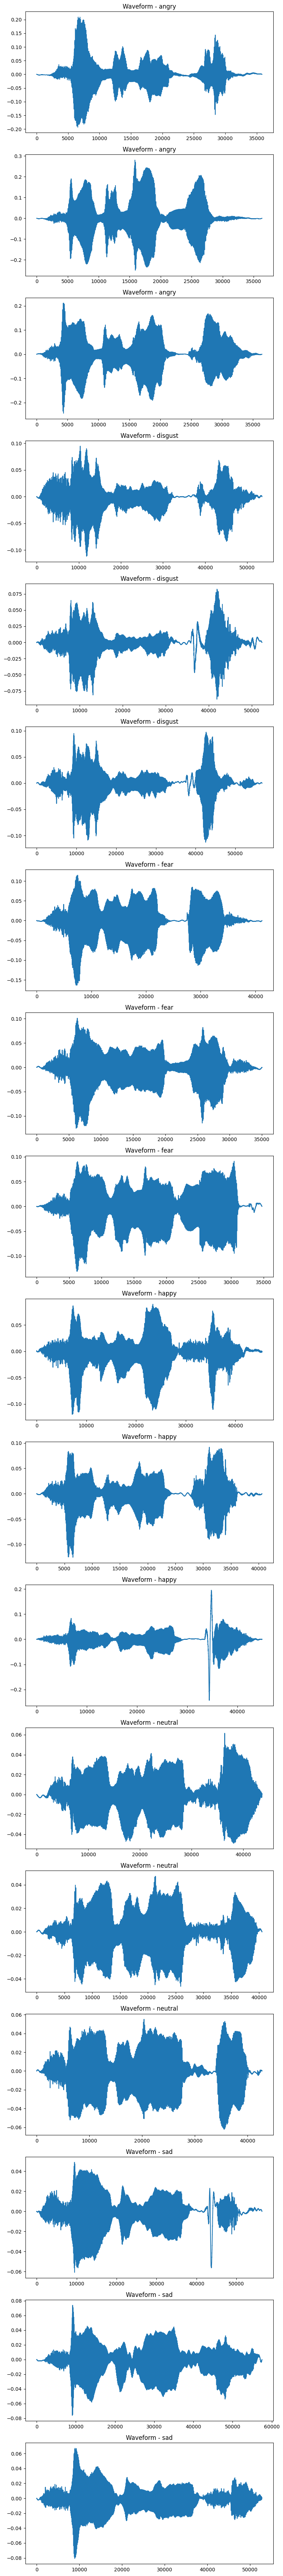

In [9]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()


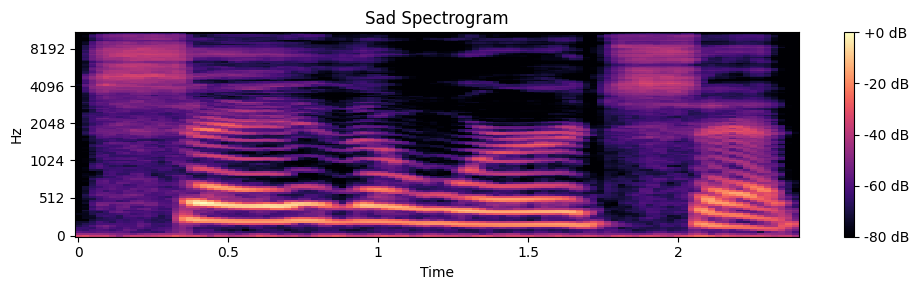

In [11]:

spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert power spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sad Spectrogram')
plt.tight_layout()
plt.show()
Audio(file_path)

In [13]:
# Encode the emotion labels
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != 1)[0]  # Get the indices from the tuple
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


In [15]:
#Build the cnn model architeture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1, 1), padding='same'))

# Flatten the output
model.add(Flatten())

# Add a dense layer0
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 1, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,862 (54.15 KB)

 Trainable params: 13,862 (54.15 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2770 - loss: 4.8347 - val_accuracy: 0.5167 - val_loss: 1.1211
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5459 - loss: 1.0864 - val_accuracy: 0.6625 - val_loss: 0.8835
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6943 - loss: 0.8020 - val_accuracy: 0.7167 - val_loss: 0.7340
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7658 - loss: 0.6390 - val_accuracy: 0.7979 - val_loss: 0.5930
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7897 - loss: 0.5517 - val_accuracy: 0.8271 - val_loss: 0.5346
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8188 - loss: 0.4940 - val_accuracy: 0.8438 - val_loss: 0.4821
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.4384 - val_accuracy: 0.8188 - val_loss: 0.4286
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8410 - loss: 0.4106 - val_accuracy: 0.8667 - val_

In [17]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8671 - loss: 0.3082
Accuracy of our model on test data :  86.87499761581421 %


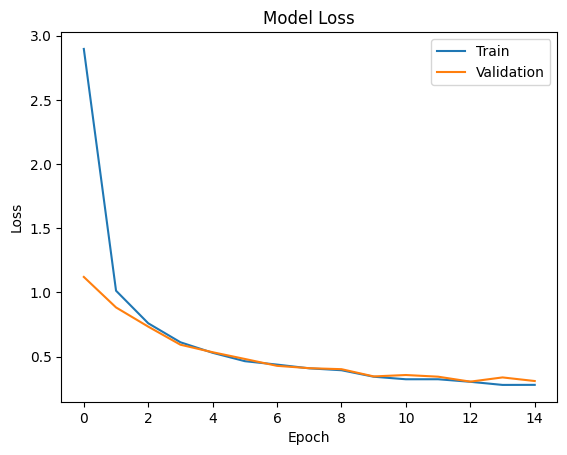

In [18]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


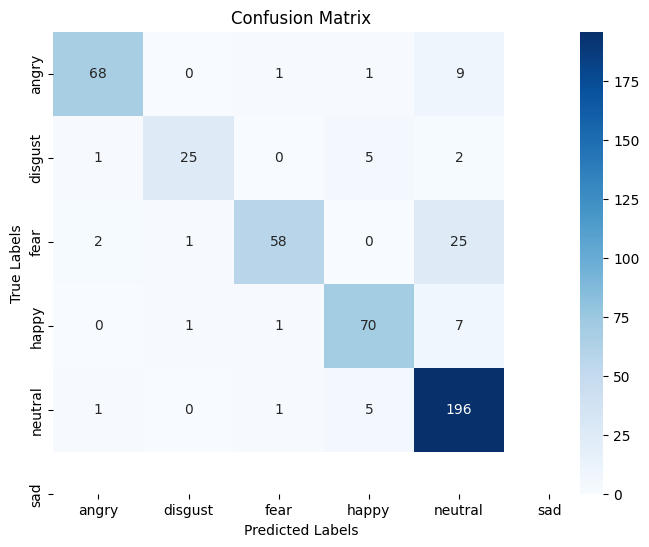

In [20]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [21]:
print(report)

              precision    recall  f1-score   support

       angry       0.94      0.86      0.90        79
     disgust       0.00      0.00      0.00         0
        fear       0.93      0.76      0.83        33
       happy       0.95      0.67      0.79        86
     neutral       0.86      0.89      0.88        79
         sad       0.82      0.97      0.89       203

    accuracy                           0.87       480
   macro avg       0.75      0.69      0.71       480
weighted avg       0.88      0.87      0.87       480



In [23]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=15, batch_size=64)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9182 - loss: 0.2276 - val_accuracy: 0.9045 - val_loss: 0.2505
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9247 - loss: 0.2065 - val_accuracy: 0.8924 - val_loss: 0.2602
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9296 - loss: 0.2021 - val_accuracy: 0.9010 - val_loss: 0.2472
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9249 - loss: 0.2108 - val_accuracy: 0.8958 - val_loss: 0.2411
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9259 - loss: 0.2042 - val_accuracy: 0.9080 - val_loss: 0.2370
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9235 - loss: 0.1985 - val_accuracy: 0.8872 - val_loss: 0.2634
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9128 - loss: 0.2054 - val_accuracy: 0.8976 - val_loss: 0.2807
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9159 - loss: 0.2067 - val_accuracy: 0.8889 - v

In [24]:
print("Accuracy of our model on train data : " , model.evaluate(X_train,y_train)[1]*100 , "%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9340 - loss: 0.1766
Accuracy of our model on train data :  92.34374761581421 %


In [29]:
# Save model and weights
model_name = 'Speech_emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\Sanjay\Desktop\task1\saved_models\Speech_emotion_Model.h5 
